In [1]:
import glob 
import os, copy, time
import random
import numpy as np
import torch

torch.manual_seed(2)
random.seed(2)
np.random.seed(2)

import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, Laplace
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

import poisevae
from poisevae.datasets import MNIST_SVHN
from poisevae.networks.MNISTSVHNNetworks import EncMNIST, DecMNIST, EncSVHN, DecSVHN



plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False

In [2]:
HOME_PATH = os.path.expanduser('~')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
MNIST_PATH = os.path.join(HOME_PATH, 'Datasets/MNIST/%s.pt')
SVHN_PATH = os.path.join(HOME_PATH, 'Datasets/SVHN/%s_32x32.mat')

joint_dataset_train = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'train', svhn_mat_path=SVHN_PATH % 'train')
joint_dataset_test = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'test', svhn_mat_path=SVHN_PATH % 'test')

In [5]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=False, drop_last=True)
len(train_loader), len(test_loader)

(937, 156)

In [6]:
lat1, lat2 = 32, 32
enc_mnist = EncMNIST(lat1).to(device)
dec_mnist = DecMNIST(lat1).to(device)
enc_svhn = EncSVHN(lat2).to(device)
dec_svhn = DecSVHN(lat2).to(device)

# Options: 'autograd' and 'gradient'
vae = poisevae.POISEVAE_Gibbs('autograd',
                              [enc_mnist, enc_svhn], [dec_mnist, dec_svhn], likelihoods=[Laplace, Laplace],
                              latent_dims=[lat1, (lat2, 1, 1)], enc_config='nu', KL_calc='derivative', 
                              batch_size=batch_size
                             ).to(device)

In [7]:
enc_mnist_init_state_dict = copy.deepcopy(enc_mnist.state_dict())
dec_mnist_init_state_dict = copy.deepcopy(dec_mnist.state_dict())
enc_svhn_init_state_dict = copy.deepcopy(enc_svhn.state_dict())
dec_svhn_init_state_dict = copy.deepcopy(dec_svhn.state_dict())

In [8]:
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [9]:
epoch = 0

In [10]:
# vae, _, epoch = poisevae.utils.load_checkpoint(vae, load_path='training_15.pt')
# epoch

In [11]:
epochs = 30 + epoch
fname = 'out%s.txt' % time.strftime('%m%d%H%M%S')
for epoch in tqdm(range(epoch, epochs)):
    with poisevae._debug.Capturing(fname, disable_print=False) as output:
        poisevae.utils.train(vae, train_loader, optimizer, epoch, None)
        poisevae.utils.test(vae, test_loader, epoch, None)
    if (epoch+1) % 10 == 0:
        poisevae.utils.save_checkpoint(vae, optimizer, 'training_%d.pt' % (epoch+1), epoch+1)
        

100%|█████████████████████████████████████████████████████████████████████████| 30/30 [22:33<00:00, 45.12s/it]


In [12]:
poisevae.utils.save_checkpoint(vae, optimizer, 'training_%d.pt' % (epoch+1), epoch+1)

In [13]:
enc_mnist_end_state_dict = enc_mnist.state_dict()
dec_mnist_end_state_dict = dec_mnist.state_dict()
enc_svhn_end_state_dict = enc_svhn.state_dict()
dec_svhn_end_state_dict = dec_svhn.state_dict()

In [14]:
def state_dict_compare(init, end):
    for k, v in end.items():
        print((v == init[k]).all().item(), end=' ')
    print()

print('enc_mnist'); state_dict_compare(enc_mnist_init_state_dict, enc_mnist_end_state_dict)
print('dec_mnist'); state_dict_compare(dec_mnist_init_state_dict, dec_mnist_end_state_dict)
print('enc_svhn'); state_dict_compare(enc_svhn_init_state_dict, enc_svhn_end_state_dict)
print('dec_svhn'); state_dict_compare(dec_svhn_init_state_dict, dec_svhn_end_state_dict)

enc_mnist
False False False False False False False False 
dec_mnist
False False False False False False 
enc_svhn
False False False False False False False False False False 
dec_svhn
False False False False False False False False 


## Results

In [7]:
vae, _, epoch = poisevae.utils.load_checkpoint(vae, load_path='training_30.pt')
# epoch

### Reconstruction

In [8]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        with poisevae._debug.Capturing() as output:
            results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)])#, 
                          # n_gibbs_iter=30)
        break

In [9]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
    x_rec = [x_rec[0].loc, x_rec[1].loc]
    # idx = torch.where(results['weights'] == results['weights'].max(dim=1).values[:, None])
    # x_rec = [x_rec[0].loc[idx], x_rec[1].loc[idx]] # (batch, IW samples, ...)

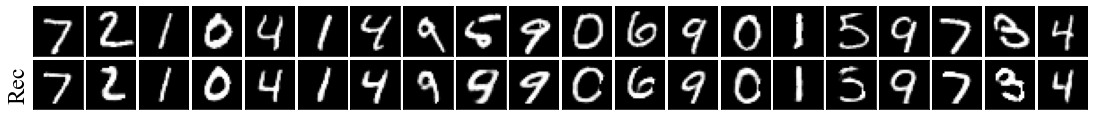

In [10]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], x_rec[0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

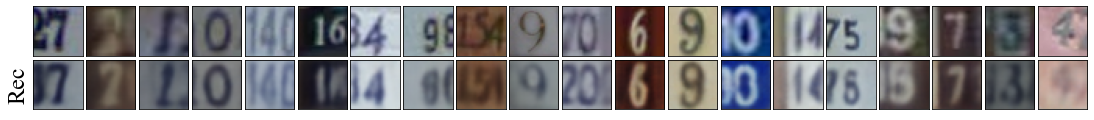

In [11]:
ncols = min(len(x_rec[1]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[1], x_rec[1])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().transpose(1, 2, 0), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'SVHNRec.pdf', dpi=300)

### Cross Generation

#### MNIST -> SVHN

In [12]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        with poisevae._debug.Capturing() as output:
            results = vae([data[0].to(device, dtype=torch.float32), None], n_gibbs_iter=100)
        break

In [13]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
    x_rec = [x_rec[0].loc, x_rec[1].loc]
    
x_rec[1].shape, data[1].shape

(torch.Size([64, 3, 32, 32]), torch.Size([64, 3, 32, 32]))

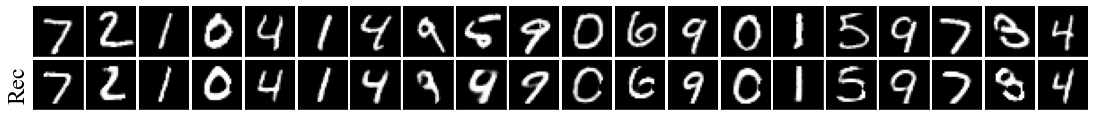

In [14]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], x_rec[0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

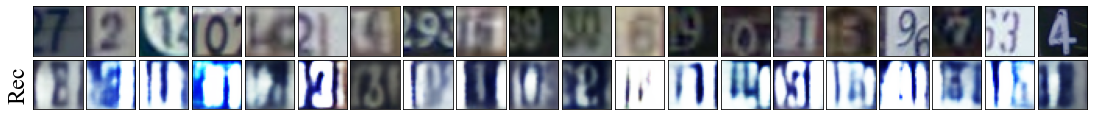

In [15]:
ncols = min(len(x_rec[1]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[1], x_rec[1])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().transpose(1, 2, 0), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'SVHNRec.pdf', dpi=300)

#### MNIST <- SVHN

In [16]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        with poisevae._debug.Capturing() as output:
            results = vae([None, data[1].to(device, dtype=torch.float32)], n_gibbs_iter=100)
        break

In [17]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
    x_rec = [x_rec[0].loc, x_rec[1].loc]
    
x_rec[1].shape, data[1].shape

(torch.Size([64, 3, 32, 32]), torch.Size([64, 3, 32, 32]))

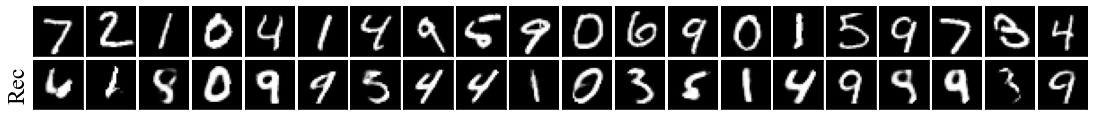

In [18]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], x_rec[0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

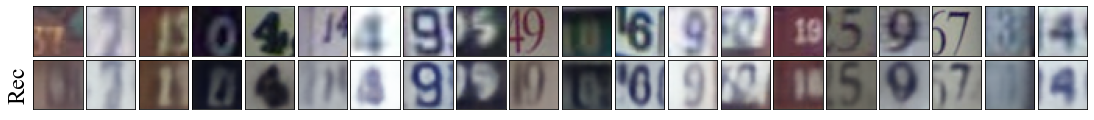

In [19]:
ncols = min(len(x_rec[1]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[1], x_rec[1])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().transpose(1, 2, 0), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'SVHNRec.pdf', dpi=300)

### Joint Generation

In [20]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        with poisevae._debug.Capturing() as output:
            results = vae([None, None], n_gibbs_iter=100)
        break

In [21]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
    x_rec = [x_rec[0].loc, x_rec[1].loc]
    
x_rec[1].shape, data[1].shape

(torch.Size([64, 3, 32, 32]), torch.Size([64, 3, 32, 32]))

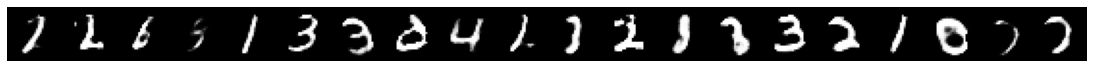

In [22]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 0.75))
for i, im in enumerate(x_rec[0]):
    if i >= ncols:
        break
    ax[i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
    # ax[i].set_xticks([])
    # ax[i].set_yticks([])
    ax[i].set_axis_off()
# ax[0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

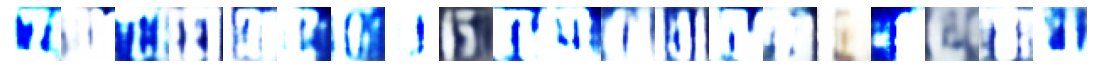

In [23]:
ncols = min(len(x_rec[1]), 20)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 0.75))
for i, im in enumerate(x_rec[1]):
    if i >= ncols:
        break
    ax[i].imshow(im.cpu().numpy().transpose(1, 2, 0), cmap='gray')
    # ax[i].set_xticks([])
    # ax[i].set_yticks([])
    ax[i].set_axis_off()
# ax[0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

## Latent Space Analysis

In [ ]:
batch_size = 3000
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)
len(train_loader), len(test_loader)

In [ ]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        label = data[-1].detach().cpu().numpy()
        data = [data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)]
        results = vae([data[0], data[1]], n_gibbs_iter=50)

        reducer = umap.UMAP(min_dist=0.01, n_neighbors=30)
        embedding = reducer.fit_transform(results['z'][0].detach().cpu().numpy())
        break
    for k in range(0, 10):
        plt.scatter(*embedding[label==k].T, c='C%d' % k, s=2)

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
path = 'runs/MNIST_SVHN/2201240015/'
vae, _, epoch = poisevae.utils.load_checkpoint(vae, load_path=os.path.join(path, 'training_80.pt'))
epoch

In [ ]:
umap_projs = {'condition': [], 'num Gibbs samples': [], 'embeddings': [], 'labels': []}

num_gibbs_s = [5, 20, 100]
with torch.no_grad():
    for i, data in enumerate(test_loader):
        label = data[-1].detach().cpu().numpy()
        data = [data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)]
        
        for i, num_gibbs in enumerate(num_gibbs_s):
            for j, (cond, data_) in enumerate(zip(('Rec', 'Joint', 'M2S', 'S2M'), 
                                                  (data, [None, None], [data[0], None], [None, data[1]]))):
                results = vae(data_, n_gibbs_iter=num_gibbs)
                
                reducer = umap.UMAP(min_dist=0.01, n_neighbors=50)
                embedding = reducer.fit_transform(results['z'][0].detach().cpu().numpy())
                
                umap_projs['condition'].append(cond)
                umap_projs['num Gibbs samples'].append(num_gibbs)
                umap_projs['embeddings'].append(embedding)
                umap_projs['labels'].append(label)
        break

In [ ]:
umap_projs_df = pd.DataFrame(umap_projs)

In [ ]:
def plot(embedding, label, color=None, *args):
    embedding = embedding.iloc[0]
    label = label.iloc[0]
    for k in range(0, 10):
        plt.scatter(*embedding[label==k].T, c='C%d' % k, s=1)

g = sns.FacetGrid(umap_projs_df, col='condition', row='num Gibbs samples', sharex=False, sharey=False, margin_titles=True, height=3.5)
g.map(plot, 'embeddings', 'labels')

In [ ]:
path = 'runs/MNIST_SVHN/2201240015/'
vae, _, epoch = poisevae.utils.load_checkpoint(vae, load_path=os.path.join(path, 'training_30.pt'))
epoch

In [ ]:
epochs = (40, 60, 80, 100)
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))
ax = ax.flatten()
for j, t in enumerate(epochs):
    vae, _, _ = poisevae.utils.load_checkpoint(vae, load_path=os.path.join(PATH, 'training_%d.pt'%t))
    G = vae.get_G().detach().cpu().numpy()#.clip(min=-100, max=100)
    im = ax[j].imshow(G)
    fig.colorbar(im, ax=ax[j])
    ax[j].set_axis_off()
    ax[j].set_title('epoch = %d' % t)
fig.tight_layout(pad=0)

In [ ]:
epochs = (40, 60, 80, 100)
fig, ax = plt.subplots(ncols=len(epochs), nrows=4, figsize=(12, 8), sharex='col')

for j, t in enumerate(epochs):
    vae, _, _ = poisevae.utils.load_checkpoint(vae, load_path=os.path.join(PATH, 'training_%d.pt'%t))
    with torch.no_grad():
        for _, data in enumerate(test_loader):
            results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)])
            break
    mu, var = results['param1'], results['param2']
    for i in (0, 1):
        ax[j, i].plot(mu[i].detach().cpu().numpy().T)
        ax[j, i].set_title('mu%d' % (i+1))
        ax[j, 2+i].plot(var[i].detach().cpu().numpy().T)
        ax[j, 2+i].set_title('var%d' % (i+1))
    ax[j, 0].set_ylabel('epoch = %d' % t)
fig.tight_layout(pad=0)

In [ ]:
epochs = (30, 40, 50)#, 60, 70, 80)
# paths = glob.glob('runs/MNIST_SVHN/22*')
fig, ax = plt.subplots(ncols=len(epochs), nrows=len(paths), figsize=(len(epochs)*2, len(paths)*2))
if len(paths) == 1:
    ax = ax[None, :]
for i, path in enumerate(paths):
    for j, t in enumerate(epochs):
        vae, _, _ = poisevae.utils.load_checkpoint(vae, load_path=os.path.join(path, 'training_%d.pt'%t))
        G = np.zeros(vae.get_G().detach().cpu().numpy().shape)
        g12_hat = vae.g12_hat.detach().cpu().numpy()
        g21_hat = vae.g21_hat.detach().cpu().numpy()
        G[:g12_hat.shape[0], g12_hat.shape[1]:] = g12_hat
        G[g21_hat.shape[0]:, :g21_hat.shape[1]] = g21_hat
        im = ax[i, j].imshow(np.abs(np.tanh(G)) < 0.8)
        # fig.colorbar(im, ax=ax[i, j])
        ax[i, j].set_axis_off()
fig.tight_layout(pad=0.1)

In [ ]:
epochs = (30, 40, 50, 60, 70, 80)
paths = glob.glob('runs/MNIST_SVHN/22*')
fig, ax = plt.subplots(ncols=2, nrows=len(paths), figsize=(8, len(paths)*1), sharex='col')
for i, path in enumerate(paths):
    for j, t in enumerate(epochs):
        vae, _, _ = poisevae.utils.load_checkpoint(vae, load_path=os.path.join(path, 'training_%d.pt'%t))
        t1 = vae.get_t()[0]
        im = ax[i, 0].plot(t1[0].detach().cpu().numpy(), c='r', alpha=0.2+j*0.8/len(epochs))
        im = ax[i, 1].plot(t1[1].detach().cpu().numpy(), c='g', alpha=0.2+j*0.8/len(epochs))
fig.tight_layout(pad=0)

In [ ]:
epochs = (30, 40, 50, 60, 70, 80)
paths = glob.glob('runs/MNIST_SVHN/22*')
fig, ax = plt.subplots(ncols=2, nrows=len(paths), figsize=(8, len(paths)*1), sharex='col')
for i, path in enumerate(paths):
    for j, t in enumerate(epochs):
        vae, _, _ = poisevae.utils.load_checkpoint(vae, load_path=os.path.join(path, 'training_%d.pt'%t))
        t2 = vae.get_t()[1]
        im = ax[i, 0].plot(np.log(-t2[0].detach().cpu().numpy()), c='r', alpha=0.2+j*0.8/len(epochs))
        im = ax[i, 1].plot(np.log(-t2[1].detach().cpu().numpy()), c='g', alpha=0.2+j*0.8/len(epochs))
fig.tight_layout(pad=0)

## Gradient Analysis

In [12]:
df = poisevae._debug.read_debug_log('out0428220631.txt')

['mu max' 'mu mean' 'mup max' 'mup mean' 'var min' 'var mean' 'varp min'
 'varp mean' 'condvar min' 'condvar mean' 'zpost max' 'zpost mean'
 'zpostp max' 'zpostp mean' 'zprior max' 'zprior mean' 'zpriorp max'
 'zpriorp mean' 'total loss' 'kl term' 'rec1 loss' 'rec2 loss']


In [13]:
df_ = df[(df.k != 'condvar mean') & (df.k != 'condvar min')]

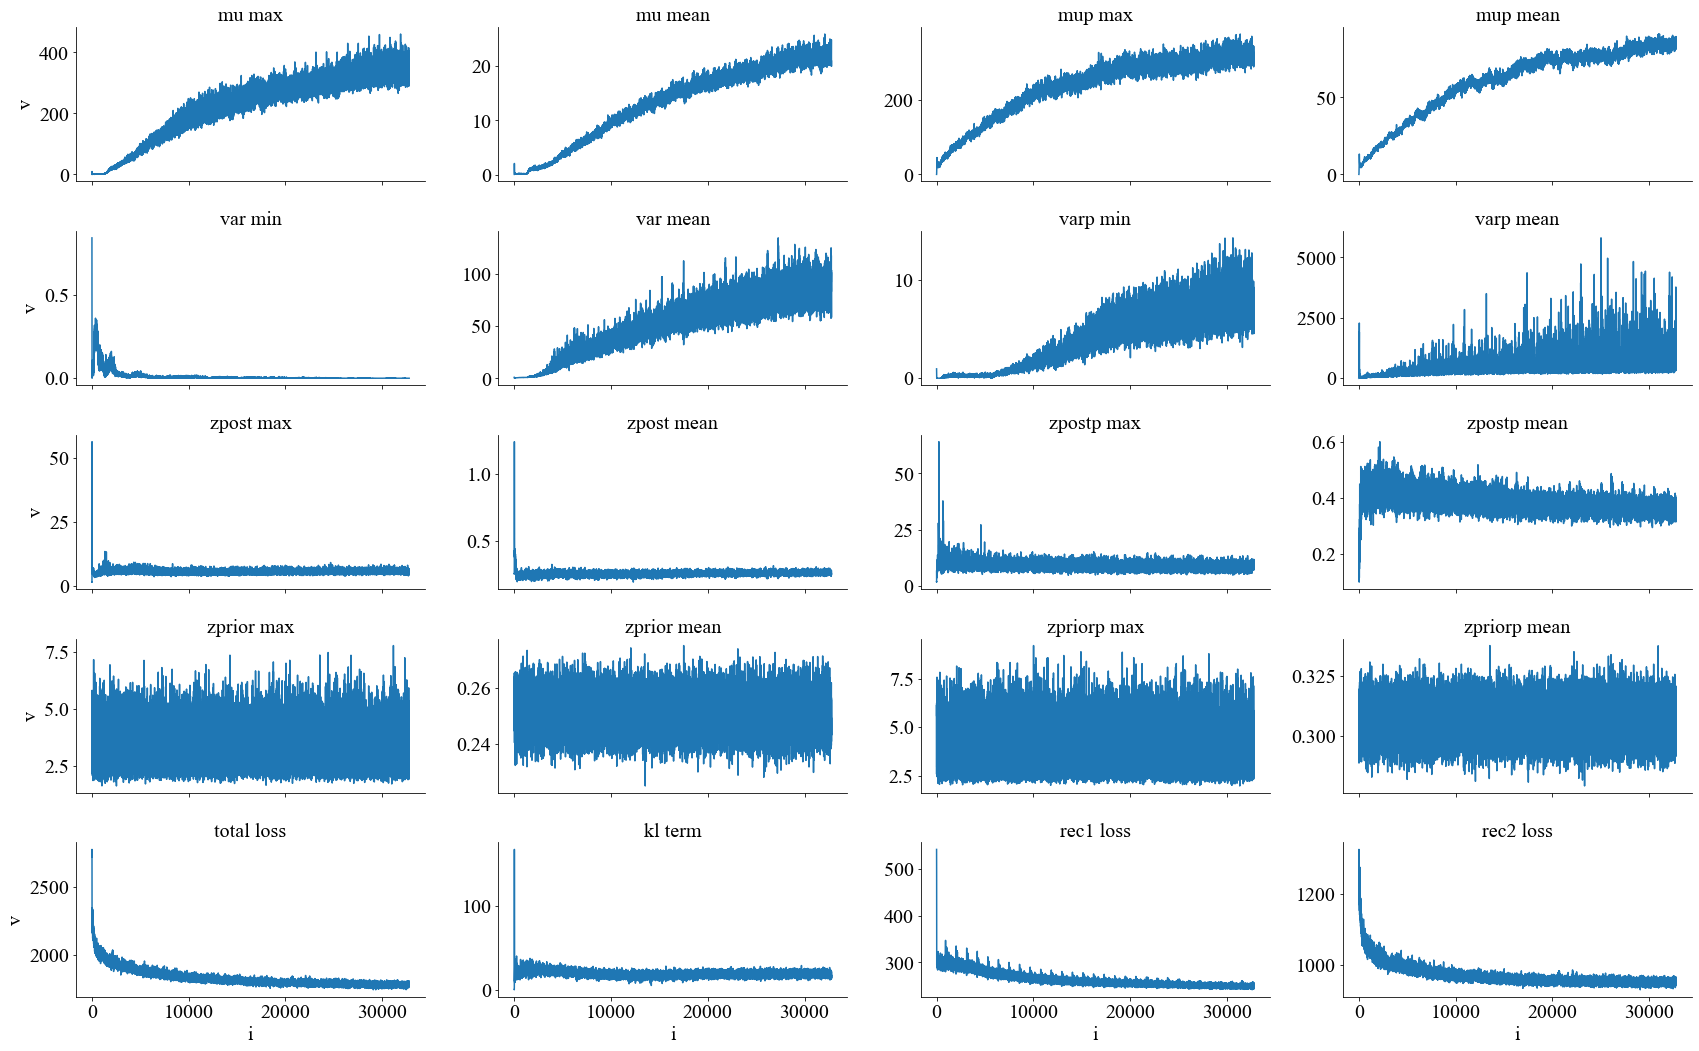

In [14]:
import seaborn as sns
g = sns.FacetGrid(data=df_, col='k', col_wrap=4, aspect=2, sharey=False)
g.map(sns.lineplot, 'i', 'v')
g.set_titles(col_template='{col_name}')
g.tight_layout()

In [ ]:
# df_dnup = df[(df.k == 'dnu1 KL') | (df.k == 'dnu2 KL')]
# g = sns.FacetGrid(data=df_dnup, col='k', col_wrap=4, ylim=[0, 1e5])
# g.map(sns.lineplot, 'i', 'v')
# g.set_titles(col_template='{col_name}')
# g.tight_layout()

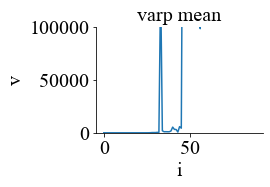

In [14]:
df_varp = df[(df.k == 'varp mean')]
g = sns.FacetGrid(data=df_varp, col='k', col_wrap=4, ylim=[0, 1e5])
g.map(sns.lineplot, 'i', 'v')
g.set_titles(col_template='{col_name}')
g.tight_layout()

In [10]:
from torchviz import make_dot

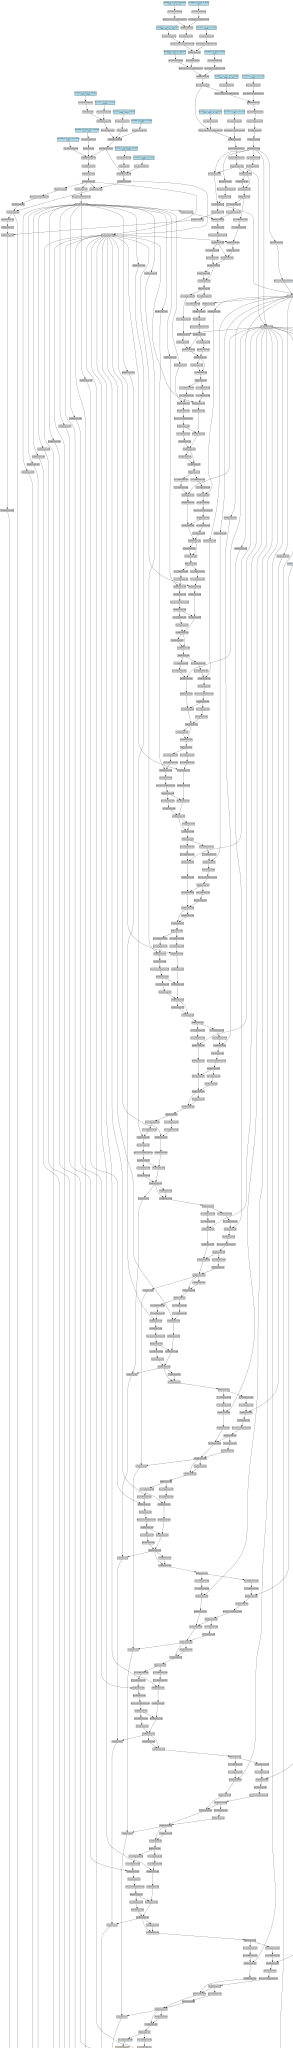

In [20]:
for i, data in enumerate(test_loader):
    with poisevae._debug.Capturing() as output:
        results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)])#, 
                      # n_gibbs_iter=30)
    break
make_dot(results['total_loss'], params=dict(vae.named_parameters()))

In [35]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        with poisevae._debug.Capturing() as output:
            param1, param2 = vae.encode([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)])
        break
param1 = [nn.Parameter(i) for i in param1]
param2 = [nn.Parameter(i) for i in param2]
G = nn.Parameter(vae.get_G())
_, t2 = vae.get_t()
# z_posteriors, kl = vae._sampling(G.detach(), param1, param2, t2, n_iterations=3)

make_dot(kl, params={'mu': param1[0], 'mup': param1[1], 'var': param2[0], 'varp': param2[1]}).render("attached", format="png")

zpost max: 1.2253451347351074 zpost mean: 0.046573933213949203
zpostp max: 1.922120451927185 zpostp mean: 0.1019628569483757
zprior max: 1.1221833229064941 zprior mean: 0.044494904577732086
zpriorp max: 2.527217388153076 zpriorp mean: 0.1179809495806694


'attached.png'